## Zillow Machine  Learning

In this notebook, let us try and explore various Machine Learning Models On Zillow Data and also learn about post model Analysis

### Objective

Building a model to improve the Zestimate residual error.

**logerror=log(Zestimate)−log(SalePrice)**

**Predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).**

### Load Libraries and Data

In [3]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import missingno as msno

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



In [4]:
# List files available
print(os.listdir("../CAPSTONE_01/"))

['Zillow_ML_Modelling_0802.ipynb', '.DS_Store', 'Zillow_DataExploration.ipynb', 'properties_2016.csv', 'README.md', 'Zillow_EDA_0719.ipynb', 'train_2016_v2.csv', '.ipynb_checkpoints', 'Data']


In [5]:
#Load Properties_2016 File
prop_df = pd.read_csv("properties_2016.csv",low_memory=False)
print('Properties file shape ',prop_df.shape)
prop_df.head()
#train_df=pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"],low_memory=False)

Properties file shape  (2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [6]:
#Train Data File
train_df=pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"],low_memory=False)
print('Train Data file shape ',train_df.shape)
train_df.head()

Train Data file shape  (90275, 3)


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


### Merge data Frames

In [7]:
#Merge Data Sets
merge_df=pd.merge(train_df,prop_df,how='left',on='parcelid')
print('Properties file shape ',merge_df.shape)
# View Merged Data Set
merge_df.info()

Properties file shape  (90275, 60)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
transactiondate                 90275 non-null datetime64[ns]
airconditioningtypeid           28781 non-null float64
architecturalstyletypeid        261 non-null float64
basementsqft                    43 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
buildingclasstypeid             16 non-null float64
buildingqualitytypeid           57364 non-null float64
calculatedbathnbr               89093 non-null float64
decktypeid                      658 non-null float64
finishedfloor1squarefeet        6856 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
finishedsquarefeet12            85596 non-null float64
finishedsquarefeet13            33 no

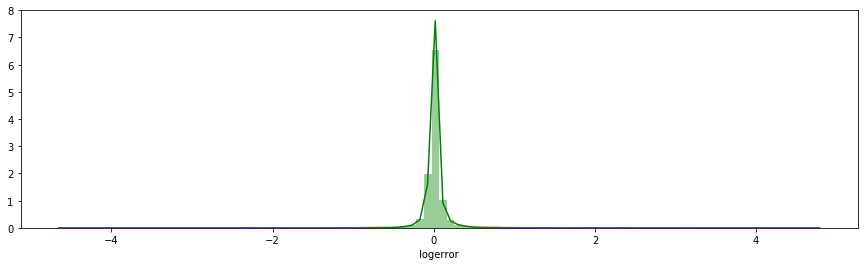

In [8]:
#Target Variable Distribution
fig, ax = plt.subplots(figsize=(15,4))
sns.distplot(merge_df['logerror'],color='g', bins=100, hist_kws={'alpha': 0.4});

In [9]:
#merge_df['airconditioningtypeid'].tail(8)
#merge_df['airconditioningtypeid'].unique().value_counts()
merge_df['architecturalstyletypeid'].value_counts()

7.0     221
8.0      16
2.0      11
21.0      8
3.0       4
10.0      1
Name: architecturalstyletypeid, dtype: int64

In [10]:
df = pd.DataFrame({'a':[1,3,3,7,4,5,6,4,7,8,9],
                   'b':[3,5,6,2,4,6,7,8,7,8,9]})
df.head()

,a,b
0,1,3
1,3,5
2,3,6
3,7,2
4,4,4


In [11]:
df['a'].unique().tolist()

[1, 3, 7, 4, 5, 6, 8, 9]

In [12]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * mis_val/ len(df)
        
   # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [13]:
missing_value=missing_values_table(merge_df)

Your selected dataframe has 60 columns.
There are 47 columns that have missing values.


In [14]:
missing_value.head(47)

,Missing Values,% of Total Values
buildingclasstypeid,90259,100.0
finishedsquarefeet13,90242,100.0
basementsqft,90232,100.0
storytypeid,90232,100.0
yardbuildingsqft26,90180,99.9
fireplaceflag,90053,99.8
architecturalstyletypeid,90014,99.7
typeconstructiontypeid,89976,99.7
finishedsquarefeet6,89854,99.5
decktypeid,89617,99.3


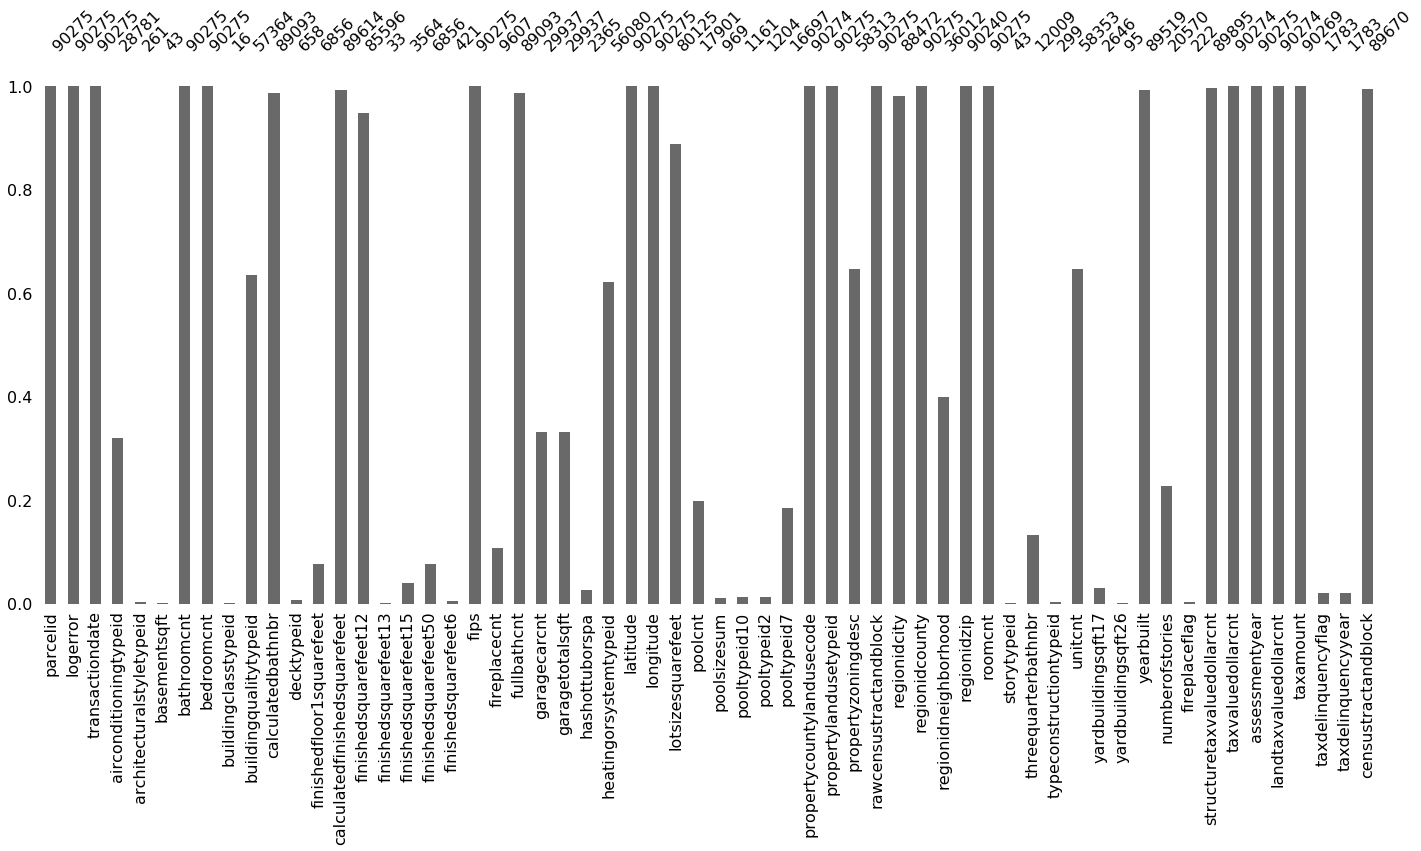

In [15]:
#Another way of visualizing Null Vaues
msno.bar(merge_df,sort='descending')

From these informations we can already see that some features won't be relevant in our exploratory analysis as there are too much missing values (such as Alley and PoolQC). Plus there is so much features to analyse that it may be better to concentrate on the ones which can give us real insights. Let's just remove parcelid,transactiondate and the features with 30% or less NaN values.

In [16]:
df2=merge_df[[column for column in merge_df if merge_df[column].count() / len(merge_df) >= 0.3]]
df2.drop(['parcelid','transactiondate'],inplace=True,axis='columns')   #Axis = 1 => Columns ,Axis =0 => Rows
df2.head()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,0.0276,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,...,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,-0.1684,NaN,3.5,4.0,NaN,3.5,2263.0,2263.0,6059.0,3.0,...,96962.0,0.0,NaN,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,-0.0040,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,...,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,0.0218,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,...,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,-0.0050,NaN,2.5,4.0,NaN,2.5,2283.0,2283.0,6059.0,2.0,...,96961.0,8.0,NaN,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [17]:
#Print Deleted Columns
print("List of dropped columns:", end=" ")
for c in merge_df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')

List of dropped columns: parcelid, transactiondate, architecturalstyletypeid, basementsqft, buildingclasstypeid, decktypeid, finishedfloor1squarefeet, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, finishedsquarefeet6, fireplacecnt, hashottuborspa, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7, storytypeid, threequarterbathnbr, typeconstructiontypeid, yardbuildingsqft17, yardbuildingsqft26, numberofstories, fireplaceflag, taxdelinquencyflag, taxdelinquencyyear, 



In [18]:
#Assign Df2 to merge_df
merge_df=df2

## Numerical Data Analysis


In [19]:
list(set(merge_df.dtypes.tolist()))

[dtype('O'), dtype('float64')]

In [20]:
df_num = merge_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,0.0276,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,...,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,-0.1684,NaN,3.5,4.0,NaN,3.5,2263.0,2263.0,6059.0,3.0,...,96962.0,0.0,NaN,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,-0.0040,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,...,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,0.0218,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,...,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,-0.0050,NaN,2.5,4.0,NaN,2.5,2283.0,2283.0,6059.0,2.0,...,96961.0,8.0,NaN,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


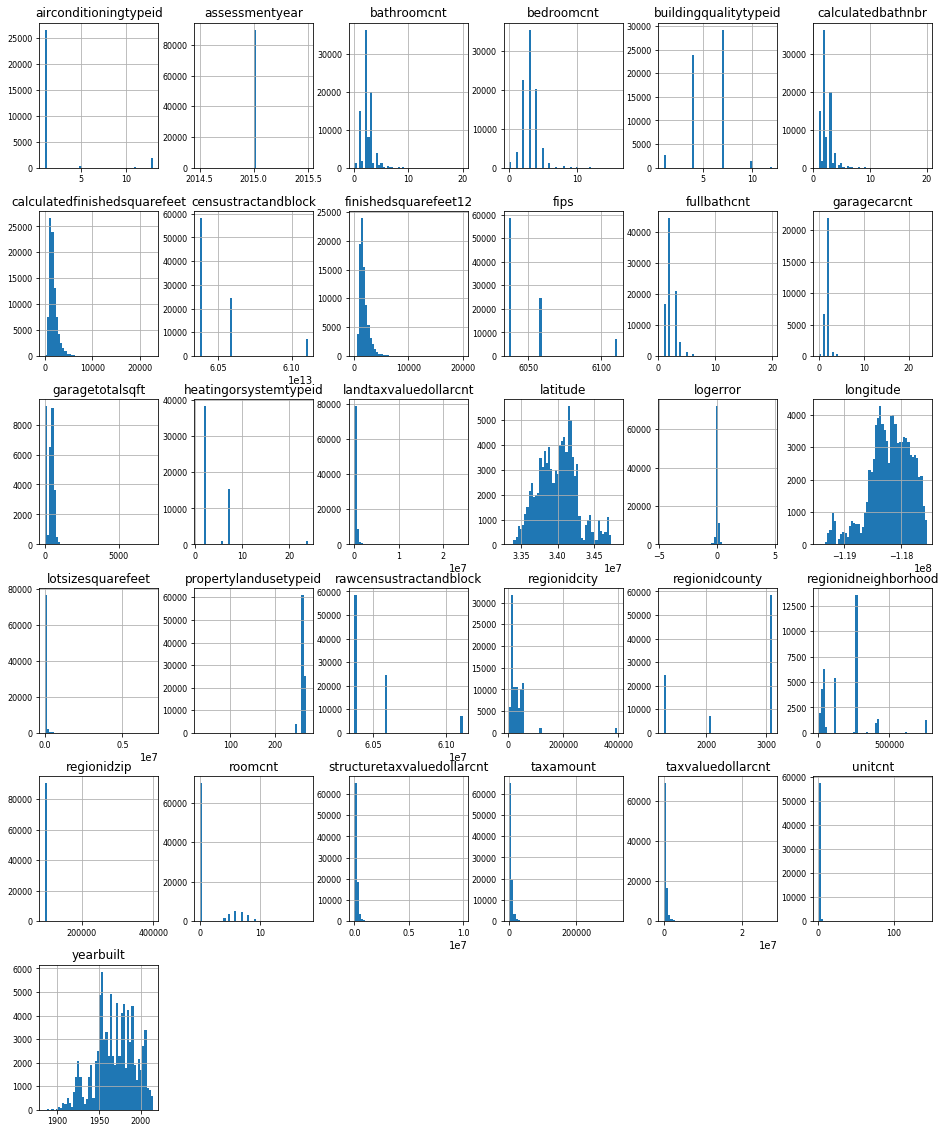

In [21]:
#Now Let's Plot them all!
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [22]:
df_num_corr = df_num.corr()['logerror'][1:] # 1 because the first row is log error
golden_features_list = df_num_corr[abs(df_num_corr) > 0.009].sort_values(ascending=False)
print("There is {} strongly correlated values with logerror:\n{}".format(len(golden_features_list), golden_features_list))

There is 12 strongly correlated values with logerror:
finishedsquarefeet12            0.041922
calculatedfinishedsquarefeet    0.038784
calculatedbathnbr               0.029448
fullbathcnt                     0.028845
bathroomcnt                     0.027889
garagecarcnt                    0.026531
bedroomcnt                      0.025467
garagetotalsqft                 0.023888
structuretaxvaluedollarcnt      0.022085
yearbuilt                       0.017312
buildingqualitytypeid          -0.009573
heatingorsystemtypeid          -0.025018
Name: logerror, dtype: float64


In [23]:
#Column Types
merge_df.dtypes.value_counts()

float64    31
object      2
dtype: int64

In [24]:
# Number of unique classes in each object column
merge_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

propertycountylandusecode      77
propertyzoningdesc           1996
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

## Encoding Categorical Variables
Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:
    1. Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. 
    2. One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.
    
The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category.

### Label Encoding

In [25]:
for f in merge_df.columns:
    if merge_df[f].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(merge_df[f].values)) 
        merge_df[f] = lbl.transform(list(merge_df[f].values))

In [26]:
merge_df.head()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,0.0276,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,...,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,-0.1684,NaN,3.5,4.0,NaN,3.5,2263.0,2263.0,6059.0,3.0,...,96962.0,0.0,NaN,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,-0.0040,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,...,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,0.0218,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,...,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,-0.0050,NaN,2.5,4.0,NaN,2.5,2283.0,2283.0,6059.0,2.0,...,96961.0,8.0,NaN,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [27]:
#View Data Type
list(set(merge_df.dtypes.tolist()))

[dtype('int64'), dtype('float64')]

### Replace NAN values

In [28]:
### Replace NaN with median values
merge_df = merge_df.fillna(merge_df.median())

### Split Train and Test data

In [29]:
merge_df.head()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,0.0276,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,2.0,...,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,-0.1684,1.0,3.5,4.0,7.0,3.5,2263.0,2263.0,6059.0,3.0,...,96962.0,0.0,1.0,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.037615e+13
2,-0.0040,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,3.0,...,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,0.0218,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,2.0,...,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,-0.0050,1.0,2.5,4.0,7.0,2.5,2283.0,2283.0,6059.0,2.0,...,96961.0,8.0,1.0,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [30]:
train_Y = merge_df.logerror.values
train_X = merge_df.drop(["logerror"], axis=1)

In [31]:
# train test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_X,train_Y,test_size = 0.3,random_state = 1)

### Feature Scaling
Before making any actual predictions, it is always a good practice to scale the features so that all of them can be uniformly evaluated

In [32]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(x_train)

x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test) 

### Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
# Predict x_test Values
predictions=model.predict(x_test)

In [35]:
# R^2 
print('R^2 score: ',model.score(x_train, y_train))

R^2 score:  0.0057356019864857055


### Cross Validation


In [36]:
from sklearn.model_selection import cross_val_score

model = LinearRegression()
k = 5
cv_result = cross_val_score(model,x_train,y_train,cv=k) # uses R^2 as score 
print('CV Scores: ',cv_result)
print('CV scores average: ',np.sum(cv_result)/k)

CV Scores:  [0.002992   0.00203567 0.00590182 0.00070172 0.00278532]
CV scores average:  0.0028833032236287083


## XGB 

In [39]:
#Import Librarires
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [45]:
#Re Read Data
properties = pd.read_csv("properties_2016.csv",low_memory=False)
train=pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"],low_memory=False)

In [46]:
#Process data for XGBoost
for c in properties.columns:
    properties[c]=properties[c].fillna(-1)
    if properties[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties[c].values))
        properties[c] = lbl.transform(list(properties[c].values))

In [47]:
train_df = train.merge(properties, how='left', on='parcelid')

In [48]:
x_train = train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
x_test = properties.drop(['parcelid'], axis=1)

In [49]:
# shape        
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

Shape train: (90275, 57)
Shape test: (2985217, 57)


In [50]:
# drop out ouliers
train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.419 ]
x_train=train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
y_train = train_df["logerror"].values.astype(np.float32)
y_mean = np.mean(y_train)


In [51]:
print('After removing outliers:')     
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

After removing outliers:
Shape train: (88528, 57)
Shape test: (2985217, 57)


In [52]:
##### RUN XGBOOST
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}


In [53]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [54]:
num_boost_rounds = 250
print("num_boost_rounds="+str(num_boost_rounds))

num_boost_rounds=250


In [55]:
# train model
print( "\nTraining XGBoost ...")
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

print( "\nPredicting with XGBoost ...")
xgb_pred1 = model.predict(dtest)

print( "\nFirst XGBoost predictions:" )
print( pd.DataFrame(xgb_pred1).head() )


Training XGBoost ...

Predicting with XGBoost ...

First XGBoost predictions:
          0
0 -0.023582
1 -0.032242
2  0.007546
3  0.064200
4 -0.004868


## Accuracy

In [56]:
from sklearn.metrics import accuracy_score

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)